# Titanic Survival
**The Challenge** (from Kaggle)

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

#### Import Modules

In [838]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

## 1. Load the Dataset
The dataset contains 14 variable columns of information on 1309 passengers.

In [839]:
df = pd.read_csv("titanic.csv")

In [840]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [841]:
df.shape

(1309, 14)

## 2. Preprocessing

In [842]:
df.dtypes

pclass        int64
survived      int64
name         object
sex          object
age          object
sibsp         int64
parch         int64
ticket       object
fare         object
cabin        object
embarked     object
boat         object
body         object
home.dest    object
dtype: object

In [843]:
df.describe()

,pclass,survived,sibsp,parch
count,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,0.498854,0.385027
std,0.837836,0.486055,1.041658,0.865560
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,1.000000,0.000000
max,3.000000,1.000000,8.000000,9.000000


### About the Variables

**pclass:** ticket class (1=1st, 2=2nd, 3=3rd)<br>
**name:** name of the passenger<br>
**sex:** sex of the passenger<br>
**age:** passenger age<br>
**sibsp:** number of siblings/spouses aboard the Titanic<br>
**parch:** number of parents/children aboard the Titanic<br>
**ticket:** ticket number<br>
**fare:** ticket fare<br>
**cabin:** cabin number<br>
**embarked:** port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)<br>
**boat:** lifeboat number<br>
**body:** body number<br>
**home.dest:** passenger home location<br>

#### Target
**survived:** if the passenger survived or not (0=No, 1=Yes)

### Data Leakage
The variables **boat** and **body** leak if the passenger survived or not, therefore these columns will be dropped. 

Additionally, **name** and **ticket** will be dropped, since they do not provide valuable data for the model.

In [844]:
df = df.drop(["boat", "body", "name", "ticket"], axis=1)

### Missing Data
Missing values seem to be represented by a question mark (?). First, the question marks will be replaced with "nan".

The sum of null values indicates the following missing values:
- **age:** 263
    - Null values will be replaced with the median age.
- **cabin:** 1014
    - Due to the high number of null values, this column will be dropped.
- **embarked:** 2
    - Null values will be replaced with most common, "S" (SouthHampton).
- **fare:** 2
    - Data will be removed as pclass provides better related predictive information.
- **home.dest:** 564
    - Due to the high cardinality (369 unique values), it is unlikely that this column will provide a contribution to the model. This column will be dropped.
    
A function will be written to resolve missing values.

In [845]:
# Replace "?" with "nan"
df = df.replace({"?": np.nan})

In [846]:
# Change age to type float
df.age = df.age.astype(np.float64)

In [847]:
df.isnull().sum()

pclass          0
survived        0
sex             0
age           263
sibsp           0
parch           0
fare            1
cabin        1014
embarked        2
home.dest     564
dtype: int64

#### Split features (X) and target (y)

In [848]:
y = df.survived
X = df.drop("survived", axis=1)

#### Drop cabin, home.dest and fare

In [849]:
X = X.drop(["cabin", "home.dest", "fare"], axis=1)

#### Replace missing embarked values with "S"

In [850]:
X.embarked.fillna('S', inplace = True)

#### Get dummies for pclass and embarked

In [851]:
X = pd.get_dummies(X, columns=["pclass", "embarked"], drop_first=True) #dropfirst = True to avoid collinearity

#### Encode sex

In [852]:
X.sex.replace({'female': 0, 'male': 1}, inplace = True)

#### Encode sibsp and parch
The variables sibsp and parch will be broken down into passengers who are alone or not alone.

In [853]:
def alone_col(X):
    if (X.sibsp == 0) & (X.parch == 0):
        return 1
    else:
        return 0
    
X["alone"] =  X.apply(alone_col, axis=1)
X = X.drop(["sibsp", "parch"], axis=1)

#### Split into train and test sets

In [854]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Impute Age
Missing age values will be imputed with the median, as explained in the missing values section.

In [855]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
X_train = X_train.copy()
X_train.loc[:, 'age'] = imputer.fit_transform(np.array(X_train.age).reshape(-1, 1))
X_test = X_test.copy()
X_test.loc[:, 'age'] = imputer.transform(np.array(X_test.age).reshape(-1, 1))

#### Scale Data
The **age** data will be standardized to ensure variables are on the same scale. 

In [856]:
scaler = preprocessing.StandardScaler()
X_train.loc[:, 'age'] = scaler.fit_transform(np.array(X_train.age).reshape(-1, 1))
X_test.loc[:, 'age'] = scaler.transform(np.array(X_test.age).reshape(-1, 1))

In [857]:
X_train.head()

,sex,age,pclass_2,pclass_3,embarked_Q,embarked_S,alone
772,1,-0.956568,0,1,0,1,1
543,1,0.529551,1,0,0,1,1
289,0,-0.878352,0,0,0,1,0
10,1,1.389936,0,0,0,0,0
147,1,-0.096184,0,0,0,1,1


## 3. Explore the Data

### age
- The ages of the passengers on the Titanic range from less than 1 year old to 80 years old.

Text(0.5, 1.0, 'Age Distribution')

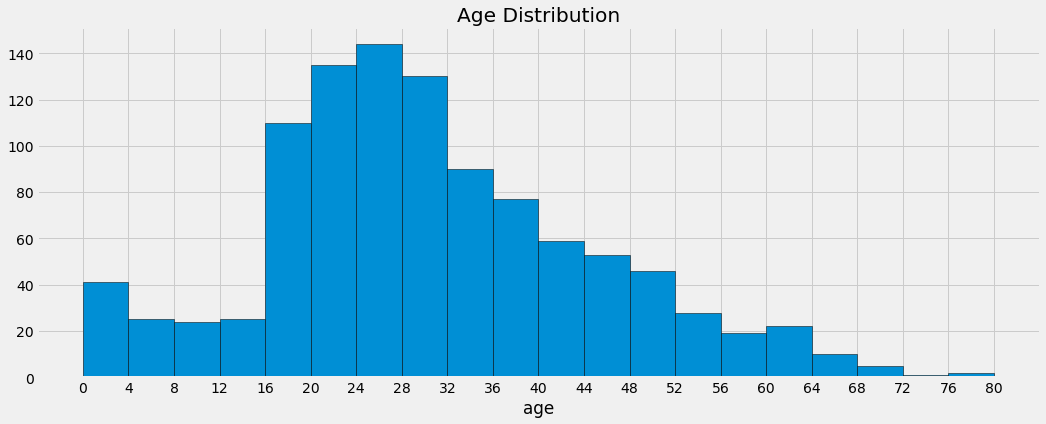

In [858]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(16,6))
n, bins, patches = plt.hist(round(X.age, 0), ec="black", bins=20)
plt.xlabel("age")
plt.xticks(bins)
plt.title("Age Distribution")

<AxesSubplot:xlabel='age', ylabel='Density'>

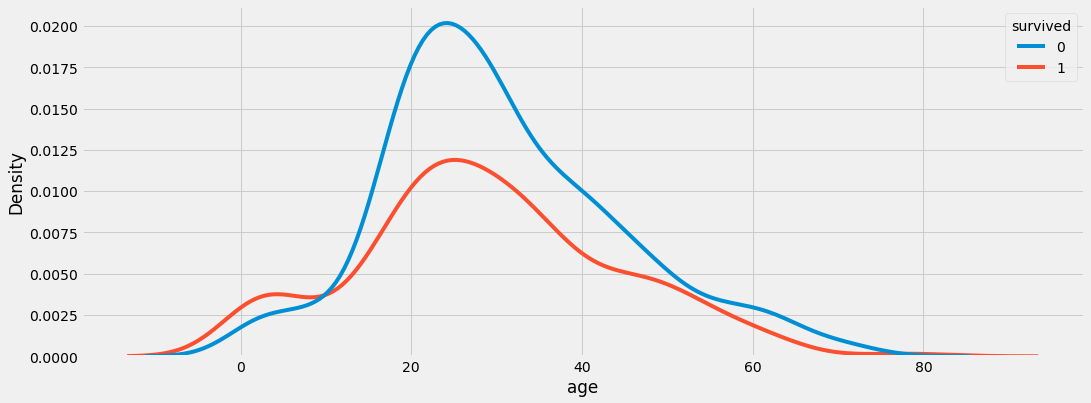

In [859]:
fig = plt.figure(figsize=(16,6))
sns.kdeplot(data=df, x="age", hue="survived")

### pclass
- 55% of passengers were 3rd class, 24% were 1st class, and 21% were 2nd class.
- The majority of 3rd class passengers did not survive, about half of 2nd class passengers survived, and more than half 1st class passengers survived.

Text(0.5, 1.0, 'Survival by Class')

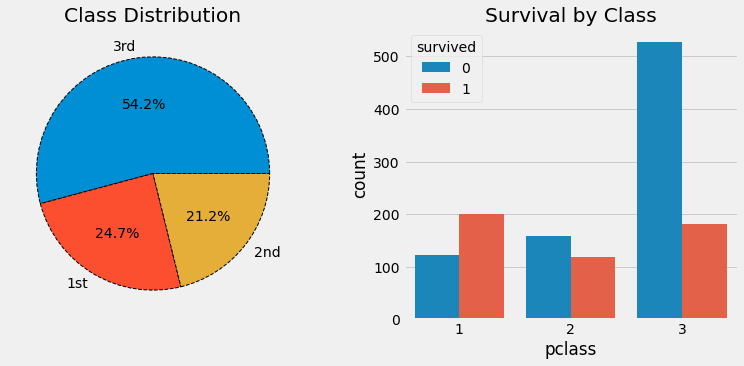

In [860]:
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
plt.pie(x=df.pclass.value_counts(), labels=["3rd", "1st", "2nd"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1, "linestyle":"dashed"})
plt.title("Class Distribution")

plt.subplot(1,2,2)
sns.countplot(data=df, x="pclass", hue="survived")
plt.title("Survival by Class")

### alone

About 60% of passengers were alone on the voyage. Almost 50% of passengers who were not alone survived, but only about 25% of passengers who were alone survived.

([<matplotlib.patches.Wedge at 0x1cace4bda90>,
 [Text(-0.35144735432863977, 1.0423457953747401, 'alone'),
  Text(0.35144735432863944, -1.0423457953747401, 'not alone')],
 [Text(-0.1916985569065308, 0.5685522520225854, '60.4%'),
  Text(0.19169855690653057, -0.5685522520225855, '39.6%')])

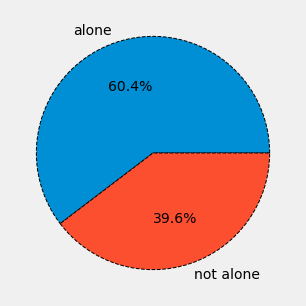

In [861]:
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
plt.pie(x=X.alone.value_counts(), labels=["alone", "not alone"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1, "linestyle":"dashed"})

### sex
About 65% of passengers were male. More female passengers survived than male passengers.

Text(0.5, 1.0, 'Survival by Sex')

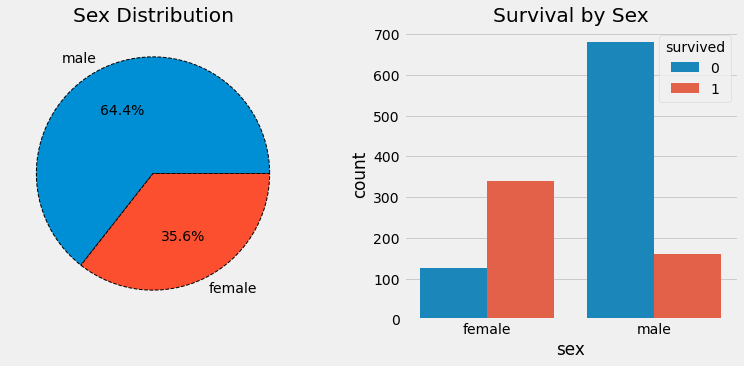

In [862]:
plt.figure(figsize=(12, 5))
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
plt.pie(x=df.sex.value_counts(), labels=["male", "female"], autopct="%1.1f%%", 
        wedgeprops={"edgecolor":"0","linewidth": 1, "linestyle":"dashed"})
plt.title("Sex Distribution")

plt.subplot(1,2,2)
sns.countplot(data=df, x="sex", hue="survived")
plt.title("Survival by Sex")

## 4. Baseline

In [863]:
df.survived.value_counts(normalize= True)

0    0.618029
1    0.381971
Name: survived, dtype: float64

## 5. Predictive Modeling

In [864]:
for model in [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier]:

    clf = model()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(f'{model.__name__:25}   Accuracy: {clf.score(X_test, y_test):.3f}   Precision: {precision_score(y_test, predictions):.3f}   Recall: {recall_score(y_test, predictions):.3f}\n')

LogisticRegression          Accuracy: 0.775   Precision: 0.831   Recall: 0.627

DecisionTreeClassifier      Accuracy: 0.744   Precision: 0.793   Recall: 0.585

KNeighborsClassifier        Accuracy: 0.733   Precision: 0.779   Recall: 0.568

RandomForestClassifier      Accuracy: 0.740   Precision: 0.791   Recall: 0.576



### Logistic Regression
Logistic Regression was the best performing model, with an accuracy of 77.5%.

<Figure size 864x432 with 0 Axes>

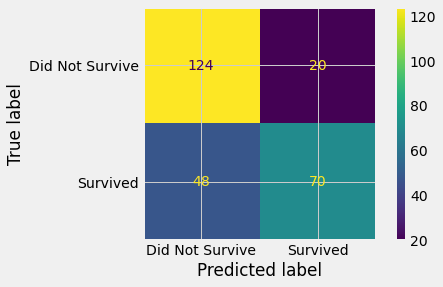

In [865]:
lr = model()
lr.fit(X_train, y_train)

fig = plt.figure(figsize=(12,6))
plot_confusion_matrix(lr, X_test, y_test, display_labels=["Did Not Survive", "Survived"])  